In [1]:
import os
import pandas as pd
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import squarify

In [2]:
INPUT_FILE = os.path.join('input', 'stocks.csv')
OUTPUT_DIR = 'output'

os.makedirs(OUTPUT_DIR, exist_ok = True)

In [3]:
stock = yf.Ticker('F')
info = stock.info
counter = 1
for key, value in info.items():
    counter = counter + 1
    if counter < 10:
        print(f'{key} - {value}')

address1 - One American Road
city - Dearborn
state - MI
zip - 48126
country - United States
phone - 313 322 3000
website - https://www.ford.com
industry - Auto Manufacturers


In [4]:
try:
    # Read the CSV file
    df = pd.read_csv(INPUT_FILE)
    
    # Fetch stock data and add new columns
    industries = []
    for index, row in df.iterrows():
        try:
            stock = yf.Ticker(row['Ticker'])
            info = stock.info
            price = info.get('regularMarketPreviousClose',0)   # Default to 0 if key is missing
            dividend = info.get('dividendRate', 0)             # Default to 0 if key is missing
            industry = info.get('industry', 'Unknown')         # Default to 'Unknown' if key is missing
            short_name = info.get('shortName','Unknown')
        
        except Exception as e:
            print(f"Error fetching data for {row['Ticker']}: {e}")
            price = 0.0
            dividend = 0.0
            industry = 'Unknown'

        df.at[index,'Price'] = price
        df.at[index, 'Dividend'] = dividend
        df.at[index, 'Name']= short_name
        industries.append(industry)
    
    # Add industries to the DataFrame
    df['Industry'] = industries

    # Calculate total investment and expected annual dividends
    df['Total Investment'] = (df['Shares']*df['Price']).round(0)
    df['Expected Dividends'] = (df['Shares']*df['Dividend']).round(2)

    #Add "SUM" row at the bottom of the DataFrame
    sum_row = {
        'Ticker':'SUM',
        'Shares':'',
        'Price':'',
        'Dividend':'',
        'Industry':'',
        'Total Investment':df['Total Investment'].sum().round(0),
        'Expected Dividends':df['Expected Dividends'].sum().round(0),
    }

    df = pd.concat([df, pd.DataFrame([sum_row])], ignore_index = True)
    
    # Generate file name with today's date and time
    output_name = datetime.now().strftime('%Y%m%d_%H%M%S')
    output_file = os.path.join(OUTPUT_DIR, f'{output_name}_updated_stocks.csv')

    # Save the updated DataFrame to a new CSV file
    df.to_csv(output_file, index=False)
    print(f'Data saved to {output_file}')
    
except FileNotFoundError:
    print(f'Error: The file {INPUT_FILE} was not found.')
except Exception as e:
    print(f'Error: An unexpected error has occurred {e}!')

Data saved to output\20241230_192513_updated_stocks.csv


In [5]:
df

,Ticker,Shares,Price,Dividend,Name,Industry,Total Investment,Expected Dividends
0,F,50,10.03,0.6,Ford Motor Company,Auto Manufacturers,501.0,30.0
1,GOOG,50,194.04,0.8,Alphabet Inc.,Internet Content & Information,9702.0,40.0
2,C,50,71.0,2.18,"Citigroup, Inc.",Banks - Diversified,3550.0,109.0
3,AAPL,50,255.59,1.0,Apple Inc.,Consumer Electronics,12780.0,50.0
4,A,10,135.54,0.99,"Agilent Technologies, Inc.",Diagnostics & Research,1355.0,9.9
5,B,20,47.21,0.64,"Barnes Group, Inc.",Specialty Industrial Machinery,944.0,12.8
6,D,40,53.93,2.67,"Dominion Energy, Inc.",Utilities - Regulated Electric,2157.0,106.8
7,E,50,26.95,2.08,ENI S.p.A.,Oil & Gas Integrated,1348.0,104.0
8,SUM,,,,NaN,,32337.0,462.0


Industry distribution chart saved.
20241230_industry_distribution.png


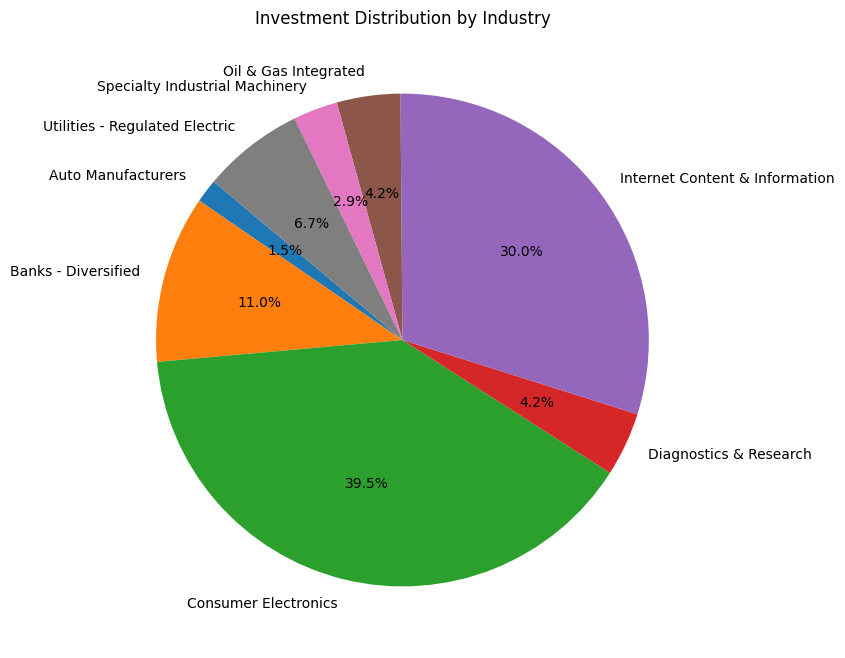

In [6]:
# Generate a pie chart for industries

today = datetime.now().strftime('%Y%m%d')

industry_data = df[df['Ticker'] != 'SUM'].groupby('Industry')['Total Investment'].sum()
plt.figure(figsize=(8, 8))
plt.pie(industry_data, labels=industry_data.index, autopct='%1.1f%%', startangle=140)
plt.title('Investment Distribution by Industry')
plt.savefig(os.path.join(OUTPUT_DIR, f'{today}_industry_distribution.png'))
print("Industry distribution chart saved.")
print(f'{today}_industry_distribution.png')

Investment treemap chart saved.
20241230_investment_treemap.png


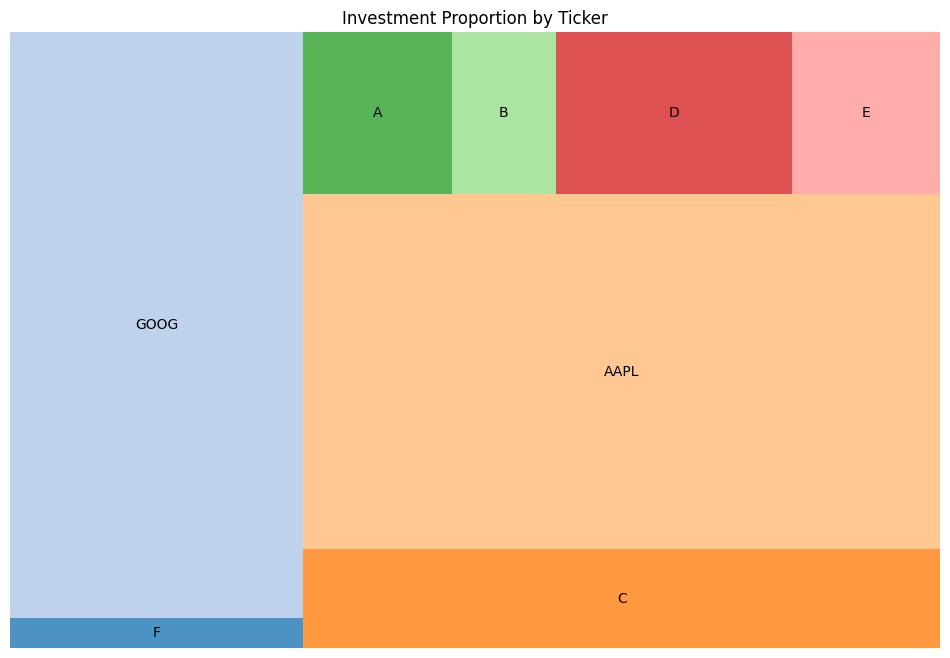

In [7]:
# Generate a treemap for investment sizes with a custom colormap
investment_data = df[df['Ticker'] != 'SUM']
plt.figure(figsize=(12, 8))
cmap = plt.colormaps['tab20']  # Accessing 'tab20' colormap
colors = [cmap(i) for i in range(len(investment_data))]  # Generate distinct colors

squarify.plot(
    sizes=investment_data['Total Investment'], 
    label=investment_data['Ticker'], 
    alpha=0.8,
    color=colors  # Pass the custom colors here
)
plt.title('Investment Proportion by Ticker')
plt.axis('off')  # Hide axes for treemap
plt.savefig(os.path.join(OUTPUT_DIR, f'{today}_investment_treemap.png'))
print(f"Investment treemap chart saved.\n{today}_investment_treemap.png")